In [113]:
import os
import tensorflow as tf
import numpy as np
import cv2
from google.colab import drive
import matplotlib.pyplot as plt
import json
%matplotlib inline
import time
from IPython.display import Image, display

drive.mount('/content/gdrive')

tf.enable_eager_execution()

layers = tf.keras.layers


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
SCALE = 32
GRID_W, GRID_H = 19, 19
N_CLASSES = 80
N_ANCHORS = 5
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH = GRID_H*SCALE, GRID_W*SCALE, 3

LAMBDA_COORD = 5.0
LAMBDA_NO_OBJ = 0.5
BATCH_SIZE = 10
LEARNING_RATE = 0.0001
NUM_ITERS = 100000

In [0]:
lookup_dict = np.load("/content/gdrive/My Drive/lookup_dict.npy").item()

In [0]:
def space_to_depth_x2(x):
  return tf.space_to_depth(x, block_size=2)

class yolov2(tf.keras.Model):
  def __init__(self, device='cpu:0', num_anchors=5, num_classes = 80):
    super(yolov2, self).__init__()
    self.device=device
    self.num_anchors = num_anchors
    self.num_classes = num_classes
    
    
    self.conv1 = layers.Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)
    self.bn1 = layers.BatchNormalization(name='norm_1')
    self.lrelu1 = layers.LeakyReLU(alpha=0.1)
    self.maxpool1 = layers.MaxPooling2D(pool_size=(2, 2))
    
    self.conv2 = layers.Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)
    self.bn2 = layers.BatchNormalization(name='norm_2')
    self.lrelu2 = layers.LeakyReLU(alpha=0.1)
    self.maxpool2 = layers.MaxPooling2D(pool_size=(2, 2))
    
    self.conv3 = layers.Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)
    self.bn3 = layers.BatchNormalization(name='norm_3')
    self.lrelu3 = layers.LeakyReLU(alpha=0.1)
    
    self.conv4 = layers.Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)
    self.bn4 = layers.BatchNormalization(name='norm_4')
    self.lrelu4 = layers.LeakyReLU(alpha=0.1)
    
    self.conv5 = layers.Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)
    self.bn5 = layers.BatchNormalization(name='norm_5')
    self.lrelu5 = layers.LeakyReLU(alpha=0.1)
    self.maxpool5 = layers.MaxPooling2D(pool_size=(2, 2))
    
    self.conv6 = layers.Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)
    self.bn6 = layers.BatchNormalization(name='norm_6')
    self.lrelu6 = layers.LeakyReLU(alpha=0.1)
    
    self.conv7 = layers.Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)
    self.bn7 = layers.BatchNormalization(name='norm_7')
    self.lrelu7 = layers.LeakyReLU(alpha=0.1)
    
    self.conv8 = layers.Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)
    self.bn8 = layers.BatchNormalization(name='norm_8')
    self.lrelu8 = layers.LeakyReLU(alpha=0.1)
    self.maxpool8 = layers.MaxPooling2D(pool_size=(2, 2))
    
    self.conv9 = layers.Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)
    self.bn9 = layers.BatchNormalization(name='norm_9')
    self.lrelu9 = layers.LeakyReLU(alpha=0.1)
    
    self.conv10 = layers.Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)
    self.bn10 = layers.BatchNormalization(name='norm_10')
    self.lrelu10 = layers.LeakyReLU(alpha=0.1)
    
    self.conv11 = layers.Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)
    self.bn11 = layers.BatchNormalization(name='norm_11')
    self.lrelu11 = layers.LeakyReLU(alpha=0.1)
    
    self.conv12 = layers.Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)
    self.bn12 = layers.BatchNormalization(name='norm_12')
    self.lrelu12 = layers.LeakyReLU(alpha=0.1)
    
    self.conv13 = layers.Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)
    self.bn13 = layers.BatchNormalization(name='norm_13')
    self.lrelu13 = layers.LeakyReLU(alpha=0.1)
    self.maxpool13 = layers.MaxPooling2D(pool_size=(2, 2))
    
    self.conv14 = layers.Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)
    self.bn14 = layers.BatchNormalization(name='norm_14')
    self.lrelu14 = layers.LeakyReLU(alpha=0.1)
    
    self.conv15 = layers.Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)
    self.bn15 = layers.BatchNormalization(name='norm_15')
    self.lrelu15 = layers.LeakyReLU(alpha=0.1)
    
    self.conv16 = layers.Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)
    self.bn16 = layers.BatchNormalization(name='norm_16')
    self.lrelu16 = layers.LeakyReLU(alpha=0.1)
    
    self.conv17 = layers.Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)
    self.bn17 = layers.BatchNormalization(name='norm_17')
    self.lrelu17 = layers.LeakyReLU(alpha=0.1)
    
    self.conv18 = layers.Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)
    self.bn18 = layers.BatchNormalization(name='norm_18')
    self.lrelu18 = layers.LeakyReLU(alpha=0.1)
    
    self.conv19 = layers.Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)
    self.bn19 = layers.BatchNormalization(name='norm_19')
    self.lrelu19 = layers.LeakyReLU(alpha=0.1)
    
    self.conv20 = layers.Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)
    self.bn20 = layers.BatchNormalization(name='norm_20')
    self.lrelu20 = layers.LeakyReLU(alpha=0.1)
    
    self.conv21 = layers.Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)
    self.bn21 = layers.BatchNormalization(name='norm_21')
    self.lrelu21 = layers.LeakyReLU(alpha=0.1)
    self.lamb21 = layers.Lambda(space_to_depth_x2)
    
    self.conv22 = layers.Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)
    self.bn22 = layers.BatchNormalization(name='norm_22')
    self.lrelu22 = layers.LeakyReLU(alpha=0.1)
    
    
    self.conv23 = layers.Conv2D(self.num_anchors*(5+self.num_classes), (1,1), strides = (1,1), padding='same', name='conv_23', use_bias=False)
#     self.lamb23 = layers.Lambda(space_to_depth_x2)
    
  def call(self, input, training=True):
    x = self.conv1(input)
    x = self.bn1(x, training=training)
    x = self.lrelu1(x)
    x = self.maxpool1(x)
    
    x = self.conv2(x)
    x = self.bn2(x, training=training)
    x = self.lrelu2(x)
    x = self.maxpool2(x)
    
    x = self.conv3(x)
    x = self.bn3(x, training=training)
    x = self.lrelu3(x)
    
    x = self.conv4(x)
    x = self.bn4(x, training=training)
    x = self.lrelu4(x)
    
    x = self.conv5(x)
    x = self.bn5(x, training=training)
    x = self.lrelu5(x)
    x = self.maxpool5(x)
    
    x = self.conv6(x)
    x = self.bn6(x, training=training)
    x = self.lrelu6(x)
    
    x = self.conv7(x)
    x = self.bn7(x, training=training)
    x = self.lrelu7(x)
    
    x = self.conv8(x)
    x = self.bn8(x, training=training)
    x = self.lrelu8(x)
    x = self.maxpool8(x)
    
    x = self.conv9(x)
    x = self.bn9(x, training=training)
    x = self.lrelu9(x)
    
    x = self.conv10(x)
    x = self.bn10(x, training=training)
    x = self.lrelu10(x)
    
    x = self.conv11(x)
    x = self.bn11(x, training=training)
    x = self.lrelu11(x)
    
    x = self.conv12(x)
    x = self.bn12(x, training=training)
    x = self.lrelu12(x)
    
    x = self.conv13(x)
    x = self.bn13(x, training=training)
    x = self.lrelu13(x)
    
    skip_connection = x
    
    x = self.maxpool13(x)
    
    x = self.conv14(x)
    x = self.bn14(x, training=training)
    x = self.lrelu14(x)
    
    x = self.conv15(x)
    x = self.bn15(x, training=training)
    x = self.lrelu15(x)
    
    x = self.conv16(x)
    x = self.bn16(x, training=training)
    x = self.lrelu16(x)
    
    x = self.conv17(x)
    x = self.bn17(x, training=training)
    x = self.lrelu17(x)
    
    x = self.conv18(x)
    x = self.bn18(x, training=training)
    x = self.lrelu18(x)
    
    x = self.conv19(x)
    x = self.bn19(x, training=training)
    x = self.lrelu19(x)
    
    x = self.conv20(x)
    x = self.bn20(x, training=training)
    x = self.lrelu20(x)
    
    skip_connection = self.conv21(skip_connection)
    skip_connection = self.bn21(skip_connection, training = training)
    skip_connection = self.lrelu21(skip_connection)
    skip_connection = self.lamb21(skip_connection)
    
#     print (skip_connection.shape, x.shape)
    x = layers.concatenate([skip_connection, x])
#     print (x.shape)
    
    x = self.conv22(x)
    x = self.bn22(x, training=training)
    x = self.lrelu22(x)
    
#     print (x.shape)
    self.grid_h = x.shape[1]
    self.grid_w = x.shape[2]
    
    x = self.conv23(x)
    y = layers.Reshape((self.grid_h, self.grid_w, self.num_anchors, 5+self.num_classes))(x)
    
    return y

In [0]:
## reference: https://github.com/WojciechMormul/yolo2

def build_loss(gt, pred):
  mask = img[1][...,5:6]
  label = img[1][...,0:5]

  mask = tf.cast(tf.reshape(mask, shape=(-1, GRID_H, GRID_W, N_ANCHORS)),tf.bool)
  masked_label = tf.boolean_mask(label, mask)
  masked_pred = tf.boolean_mask(pred, mask)
  # print (masked_label)
  # print (masked_pred)
  neg_masked_pred = tf.boolean_mask(pred, tf.logical_not(mask))

  masked_pred_xy = tf.sigmoid(masked_pred[...,0:2])
  masked_pred_wh = tf.exp(masked_pred[...,2:4])
  masked_pred_o = tf.sigmoid(masked_pred[...,4:5])
  masked_pred_no_o = tf.sigmoid(neg_masked_pred[...,4:5])
  masked_pred_c = tf.nn.softmax(masked_pred[...,5:])

  masked_label_xy = masked_label[...,0:2]
  masked_label_wh = masked_label[...,2:4]
  masked_label_c = masked_label[...,4:5]
  masked_label_c_numpy = np.zeros_like(masked_label_c.numpy())
  for i,v in enumerate(masked_label_c.numpy()):
    masked_label_c_numpy[i] = (lookup_dict[v[0]])
  masked_label_c_vec = tf.reshape(tf.one_hot(tf.cast(masked_label_c_numpy, tf.int32), depth=N_CLASSES), shape=(-1, N_CLASSES))

  loss_xy = tf.reduce_sum(tf.square(masked_pred_xy-masked_label_xy))
  loss_wh = tf.reduce_sum(tf.square(masked_pred_wh-masked_label_wh))
  loss_obj = tf.reduce_sum(tf.square(masked_pred_o - 1))
  loss_no_obj = tf.reduce_sum(tf.square(masked_pred_no_o))
  loss_c = tf.reduce_sum(tf.square(masked_pred_c - masked_label_c_vec))

  loss = LAMBDA_COORD*(loss_xy + loss_wh) + loss_obj + LAMBDA_NO_OBJ*loss_no_obj + loss_c
	
  return loss

In [0]:
def _parse_function(example_proto):

    features={'image': tf.FixedLenFeature([], tf.string),'label': tf.FixedLenFeature([], tf.string)}

    parsed_features = tf.parse_single_example(example_proto, features)
    
    image_raw = tf.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.cast(tf.reshape(image_raw, [IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH]), tf.float32)
    image = image/255.0
#     print (image)
    
    label_raw = tf.decode_raw(parsed_features['label'], tf.float32)	
    label = tf.reshape(label_raw, [GRID_H, GRID_W, N_ANCHORS, 6])

    return image, label

## Training


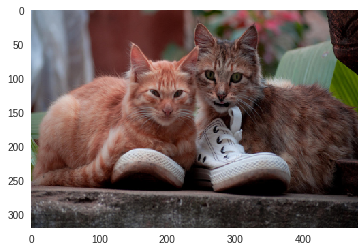

In [0]:
#Fetch from dataset
GRID_W, GRID_H = 18, 10
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH = GRID_H*SCALE, GRID_W*SCALE, 3
val_dataset = tf.data.TFRecordDataset('/content/gdrive/My Drive/cocostuff2017/val2017.tfrecord')
val_dataset = val_dataset.map(_parse_function)
val_dataset = val_dataset.shuffle(buffer_size=800)
val_dataset = val_dataset.batch(10)

for img in val_dataset:
#   print (img)
  plt.imshow(cv2.resize(img[0][0].numpy()[:,:,::-1], (480, 320)))
  plt.grid(b=None)
  break

In [0]:
## Overfit a small dataset
i=0
loss_hist = []
model = yolov2()
optimizer = tf.train.AdamOptimizer(learning_rate=0.000001)
while i<1000:
# for img in val_dataset.take(100):
# for img in val_dataset:
  with tf.device("/device:GPU:0"):
    with tf.GradientTape() as tape:
      test_pred = model(img[0])
      loss = build_loss(img[1], test_pred)
      grads = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      loss_hist.append(loss.numpy())
#       print (loss)
      i+=1
#       if(i>100):
#         break

Text(0.5, 1.0, 'overfit 10')

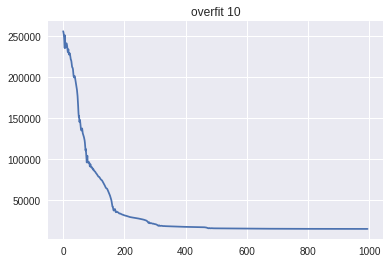

In [0]:
plt.plot(loss_hist[5:])
plt.title('overfit 10')

In [0]:
# FULL TRAINGING SCRIPT: DO NOT RUN THIS UNLESS HAVE TO, TAKES FOREVER
train_dataset = tf.data.TFRecordDataset('/content/gdrive/My Drive/cocostuff2017/train2017.tfrecord').map(_parse_function).shuffle(buffer_size=1000).batch(10)
i=0
loss_hist = []
new_model = yolov2()
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
while (i<NUM_ITERS):
  for data in train_dataset.take(100):
    with tf.device('/device:GPU:0'):
      with tf.GradientTape() as tape:
        pred = new_model(data[0])
        loss = build_loss(data[1], pred)
        grads = tape.gradient(loss, new_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, new_model.trainable_variables))
        loss_hist.append(loss.numpy())
        if i<=1000 and i%100==0:
          new_model.save_weights('./checkpoints/checkpoint_'+str(i))
          plt.figure()
          plt.plot(loss_hist[i-100:])
          plt.savefig('./loss/'+str(i)+'.png')
        elif i>1000 and i%5000==0:
          new_model.save_weights('./checkpoints/checkpoint_'+str(i))
          plt.figure()
          plt.plot(loss_hist[i-5000:])
          plt.savefig('./loss/'+str(i)+'.png')
        i+=1
        if i>NUM_ITERS:
          break

## Testing

In [0]:
prob_th = 0.7
iou_th = 0.5
n_anchors = 5
n_classes = 80
n_single_out = n_anchors + n_classes
net_scale = 32
grid_w, grid_h = 19, 19
# grid_w, grid_h = 18, 10
input_w, input_h = grid_w*net_scale, grid_h*net_scale

anchors = [[0.57273,0.677385],[1.87446,2.06253],[3.33843,5.47434],[7.88282,3.52778],[9.77052,9.16828]]


In [114]:
model = yolov2()
model.load_weights('/content/gdrive/My Drive/newweight/checkpoint')
# model.load_weights('./newweight/checkpoint')

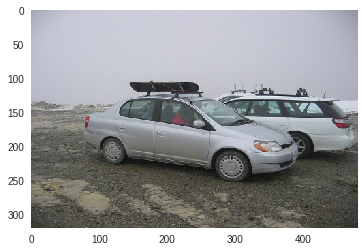

In [0]:
#Fetch from dataset
GRID_W, GRID_H = 18, 10
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH = GRID_H*SCALE, GRID_W*SCALE, 3
val_dataset = tf.data.TFRecordDataset('/content/gdrive/My Drive/cocostuff2017/val2017.tfrecord')
val_dataset = val_dataset.map(_parse_function)
val_dataset = val_dataset.shuffle(buffer_size=800)
val_dataset = val_dataset.batch(1)

for img in val_dataset:
#   print (img)
  plt.imshow(cv2.resize(img[0][0].numpy()[:,:,::-1], (480, 320)))
  plt.grid(b=None)
  break
 

In [0]:
#Or using own picture (Recommend)
img = cv2.imread('/content/55501516_418412832256411_5008024436566130688_n.jpg')
resized_image = cv2.resize(img,(608, 608), interpolation = cv2.INTER_CUBIC)
resized_image = np.array(resized_image, dtype='f')
resized_image = np.array([resized_image/255.])

In [0]:
def read_labels(filepath):
  classes, names, colors = [], [], []
  with open(filepath,'r') as file:
    lines = file.read().splitlines()
    for line in lines:
#       print(line.split(' '))
      cla, name, color = line.split(' ')
      classes.append(int(cla))
      names.append(name)
      colors.append(eval(color))
      
  return classes, names, colors

def iou(r1,r2):
  intersect_w = np.maximum(np.minimum(r1[0]+r1[2],r2[0]+r2[2])-np.maximum(r1[0],r2[0]),0)
  intersect_h = np.maximum(np.minimum(r1[1]+r1[3],r2[1]+r2[3])-np.maximum(r1[1],r2[1]),0)
  area_r1 = r1[2]*r1[3]
  area_r2 = r2[2]*r2[3]
  intersect = intersect_w*intersect_h	
  union = area_r1 + area_r2 - intersect
  
  return intersect/union

In [119]:
start = time.time()
with tf.device("/device:GPU:0"):
  pred = model(np.array([cv2.resize(img[0][0].numpy(), (608, 608))]), False)
#   pred = model(img[0], False)
#   pred = model(resized_image, False)
end = time.time()
print (end-start)

0.03789401054382324


In [122]:
## reference: https://github.com/WojciechMormul/yolo2
start = time.time()

class_ids, names, colors = read_labels('/content/gdrive/My Drive/coco_label.txt')
locations = []
classes = []

class_vecs = tf.nn.softmax(pred[:,:,:,:,5:]).numpy()
object_decs = tf.nn.sigmoid(pred[:,:,:,:,4]).numpy()
class_probs = class_vecs*object_decs[:,:,:,:,None]
classes = np.reshape(class_probs, ((tf.reduce_prod(class_probs.shape))/80, 80))


for i in range(grid_h):
  for j in range(grid_w):
    for k in range(N_ANCHORS):  
      w = np.exp(pred[0, i, j, k, 2])*anchors[k][0]*net_scale
      h = np.exp(pred[0, i, j, k, 3])*anchors[k][1]*net_scale
      dx = tf.nn.sigmoid(pred[0, i, j, k, 0]).numpy()
      dy = tf.nn.sigmoid(pred[0, i, j, k, 1]).numpy()
      x = (j+dx)*net_scale-w/2.0
      y = (i+dy)*net_scale-h/2.0
      locations.append((x,y,w,h))
      
      
classes = np.transpose(classes)
indxs = np.argsort(-classes,axis=1)
for i in range(classes.shape[0]):
  classes[i] = classes[i][indxs[i]]
for class_idx, class_vec in enumerate(classes):
  for roi_idx, roi_prob in enumerate(class_vec):
    if roi_prob < prob_th:
      classes[class_idx][roi_idx]=0
    else:
      roi = locations[indxs[class_idx][roi_idx]]
      for roi_ref_idx, roi_ref_prob in enumerate(class_vec):
        if roi_ref_prob == 0 or roi_ref_idx <= roi_idx:
          continue     

        roi_ref = locations[indxs[class_idx][roi_ref_idx]]
        if iou(roi, roi_ref) > iou_th:
          classes[class_idx][roi_ref_idx] = 0
          
out_image = img[0][0].numpy()
# out_image = resized_image[0].copy()

rois = locations
scale_w = out_image.shape[1]/float(input_w)
scale_h = out_image.shape[0]/float(input_h)

for class_idx, c in enumerate(classes):
  for loc_idx, class_prob in enumerate(c):
    if class_prob > 0:
      x = int(rois[indxs[class_idx][loc_idx]][0]*scale_w)
      y = int(rois[indxs[class_idx][loc_idx]][1]*scale_h)
      w = int(rois[indxs[class_idx][loc_idx]][2]*scale_w)
      h = int(rois[indxs[class_idx][loc_idx]][3]*scale_h)
      
      print (x,y,w,h, names[class_idx])
      
      cv2.rectangle(out_image, (x, y), (x+w, y+h), colors[class_idx], 4)
      font = cv2.FONT_HERSHEY_SIMPLEX
      text = names[class_idx] + ' %.2f'%class_prob
      if (y-8)>0:
        cv2.putText(out_image, text, (x, y-8), font, 0.7, colors[class_idx], 2, cv2.LINE_AA)
      else:
        cv2.putText(out_image, text, (x+5, 18), font, 0.7, colors[class_idx], 2, cv2.LINE_AA)
end = time.time()
print (end-start)

238 136 46 33 person
396 133 27 18 person
98 105 386 150 car
299 118 296 102 car
3.7661325931549072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


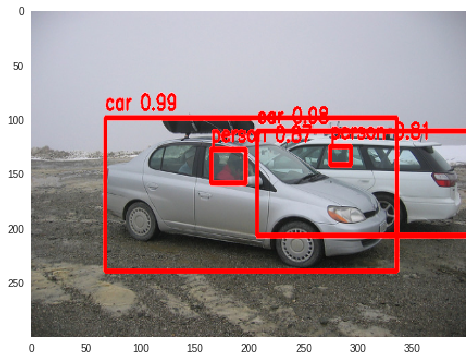

In [0]:
plt.figure(figsize=(8,6))
plt.imshow(cv2.resize(out_image[:,:,::-1], (400, 300)))
plt.grid(b=None)

In [0]:
plt.figure(figsize=(14,8))
plt.imshow(cv2.resize(out_image[:,:,::-1], (1080, 1920)))
plt.grid(b=None)